In [1]:
import warnings

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from keras.applications import VGG16
import imgaug as ia
import imgaug.augmenters as iaa
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from Reader import read_dataset
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

tf.get_logger().setLevel(3)
import cv2
import os, glob
import pandas as pd
import Helper

In [2]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
EPOCHS = 30
BATCH_SIZE = 32
SEED = 42

In [3]:
def create_model():
    input_shape = [IMAGE_WIDTH, IMAGE_HEIGHT, 3]

    # load pretrained model 'VGG16'
    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape)
    # trainable = False
    base_model.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(BatchNormalization())  # batch normalization
    model.add(Dropout(0.4))  # dropout for preventing overfitting
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation='softmax'))  # softmax classification for 4 labels

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [4]:
#Display the model layers
model_display = create_model()
model_display.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [5]:
def Cross_Validation(model, X_train, y_train, X_test, y_test):
    acc = []
    val_acc = []
    test_acc = []
    loss = []
    val_loss = []
    test_loss = []
    EPOCHS = 6
    kfold = KFold(5, shuffle=True, random_state=SEED)

    for f, (train_indices, val_indices) in enumerate(kfold.split(X=X_train, y=y_train)):
        print();
        print("#" * 50)
        print("Fold: ", f + 1)
        print("#" * 50)

        train_X, train_y = np.take(X_train, train_indices, axis=0), np.take(y_train, train_indices, axis=0)
        val_X, val_y = np.take(X_train, val_indices, axis=0), np.take(y_train, val_indices, axis=0)
        # Define start and end epoch for each folds
        fold_start_epoch = f * EPOCHS
        fold_end_epoch = EPOCHS * (f + 1)

        # fit
        history = model.fit(x=train_X, y=train_y, initial_epoch=fold_start_epoch, epochs=fold_end_epoch, validation_data=(val_X, val_y), shuffle=True, batch_size=BATCH_SIZE, steps_per_epoch=len(train_X) / BATCH_SIZE)

        score = model.evaluate(X_test, y_test, verbose=1)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        acc = np.concatenate((acc, history.history['accuracy']), axis=None)
        val_acc = np.concatenate((val_acc, history.history['val_accuracy']), axis=None)
        loss = np.concatenate((loss, history.history['loss']), axis=None)
        val_loss = np.concatenate((val_loss, history.history['val_loss']), axis=None)
        test_acc.append(score[1])
        test_loss.append(score[0])
    return model, acc, val_acc, loss, val_loss, test_acc, test_loss

In [6]:
techniques = ["Default", "Color Normalization", "CLAHE", "Gray Scale", "XYZ", "Binarization", "Mahal"]


##################################################
Fold:  1
##################################################
Epoch 1/6
36/36 [==============================] - 140s 4s/step - loss: 6.4763 - accuracy: 0.4488 - val_loss: 1.2159 - val_accuracy: 0.5729
Epoch 2/6
36/36 [==============================] - 139s 4s/step - loss: 1.0485 - accuracy: 0.5660 - val_loss: 1.2214 - val_accuracy: 0.4688
Epoch 3/6
36/36 [==============================] - 136s 4s/step - loss: 0.9685 - accuracy: 0.5938 - val_loss: 1.1718 - val_accuracy: 0.6042
Epoch 4/6
36/36 [==============================] - 134s 4s/step - loss: 0.8940 - accuracy: 0.6285 - val_loss: 1.0957 - val_accuracy: 0.6250
Epoch 5/6
36/36 [==============================] - 137s 4s/step - loss: 0.8587 - accuracy: 0.6233 - val_loss: 0.9854 - val_accuracy: 0.6250
Epoch 6/6
12/12 [==============================] - 34s 3s/step - loss: 1.0215 - accuracy: 0.5868
Test loss: 1.0214933156967163
Test accuracy: 0.586776852607727

###########################

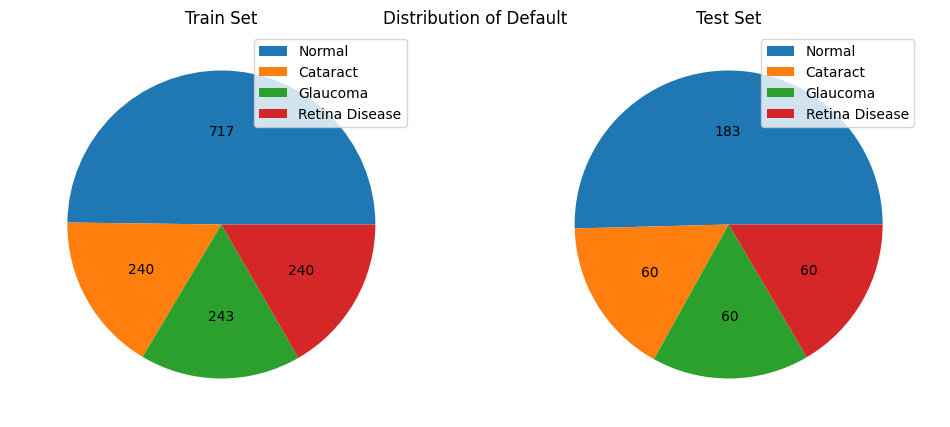

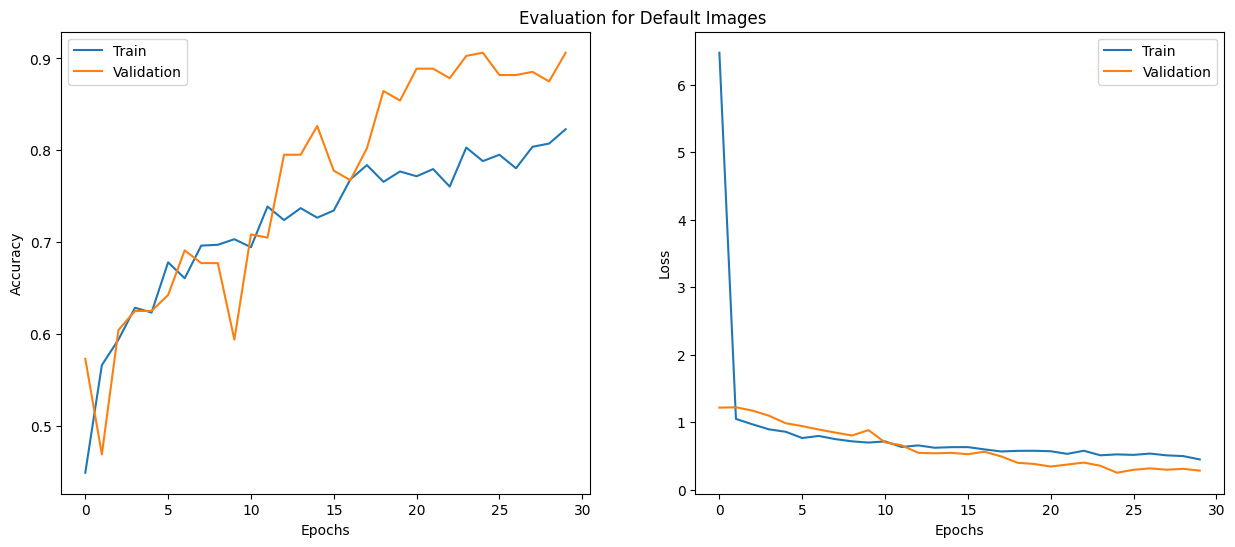

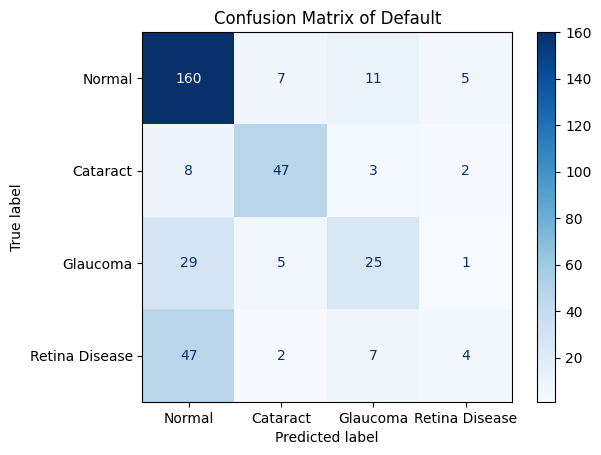

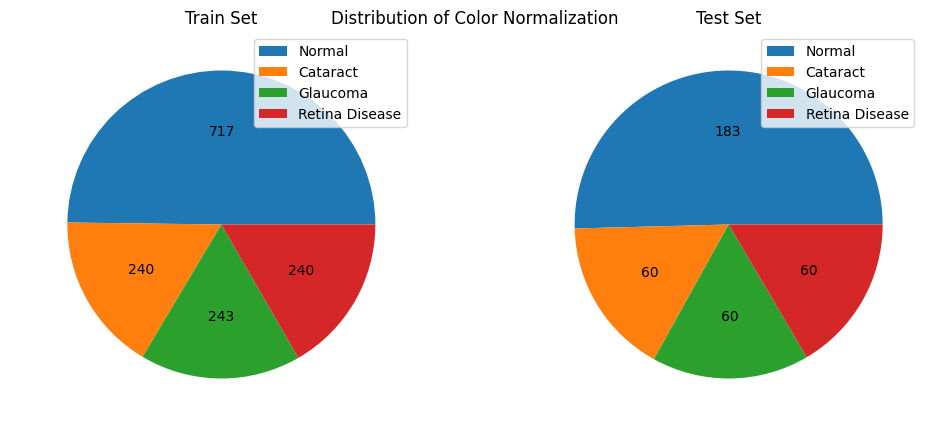

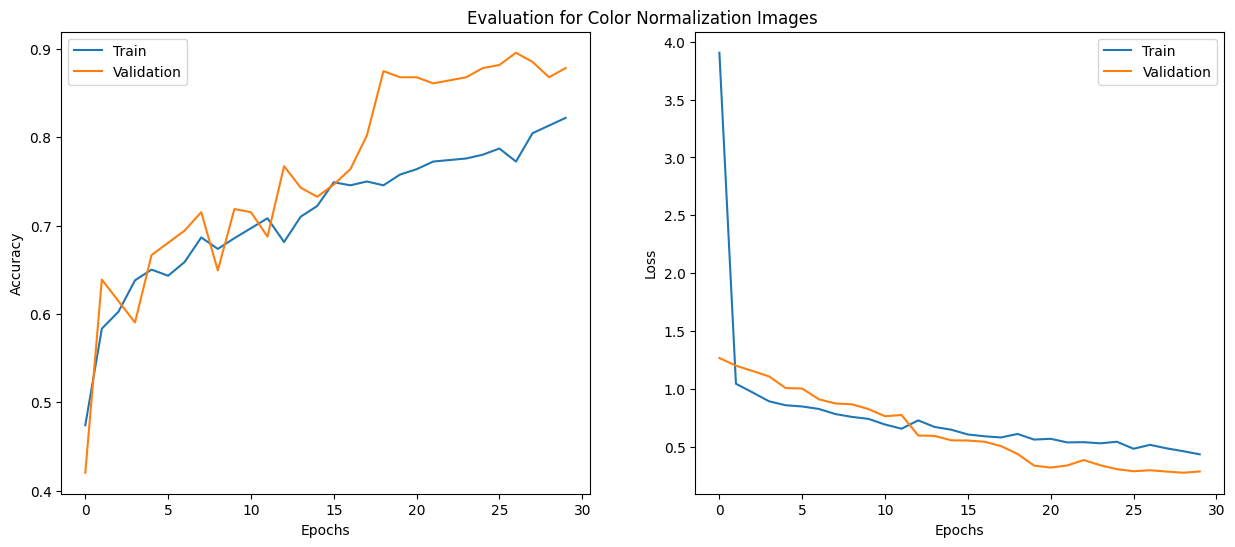

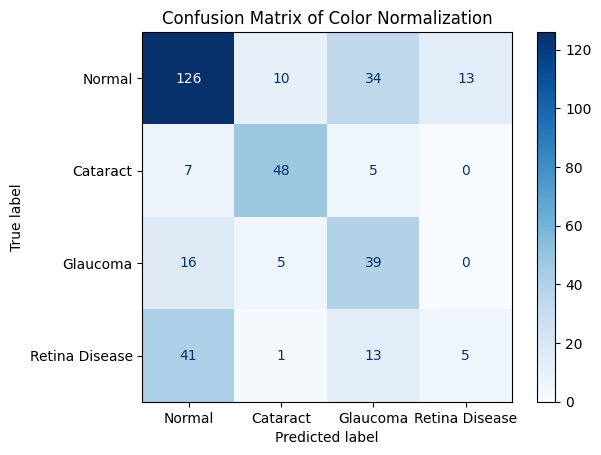

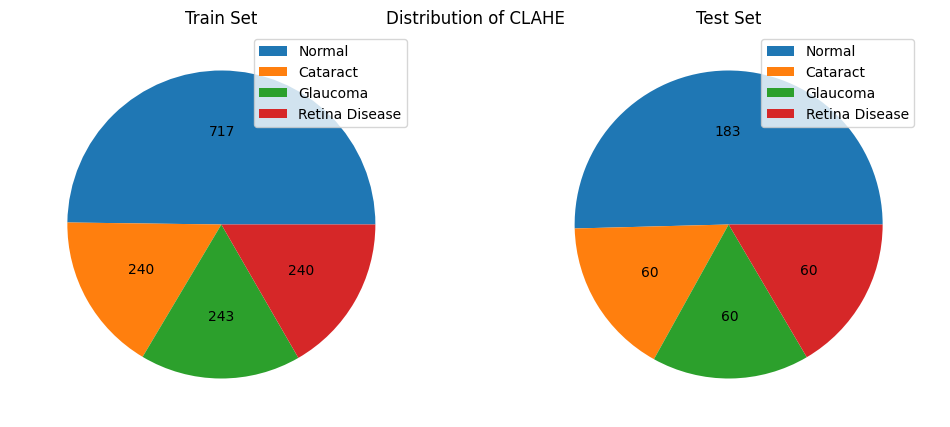

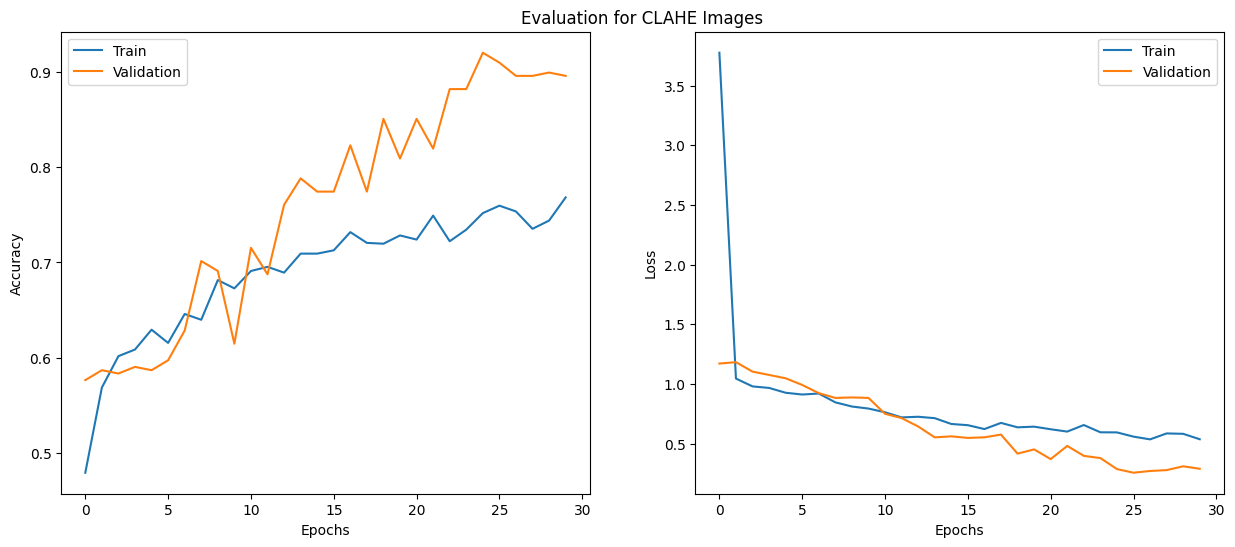

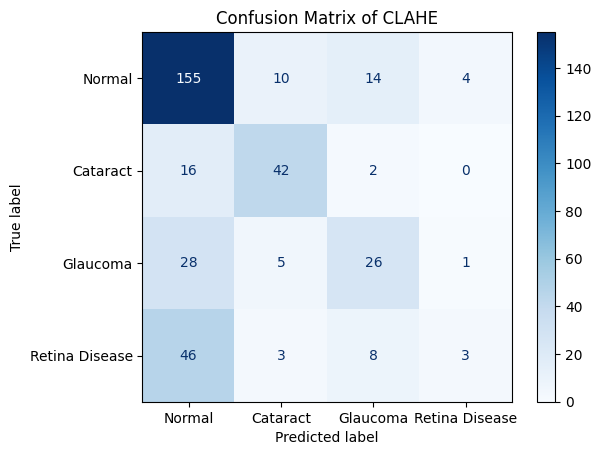

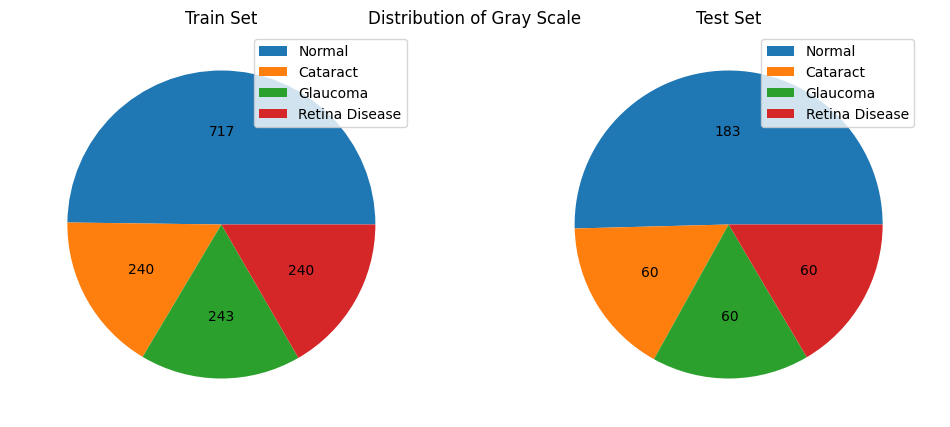

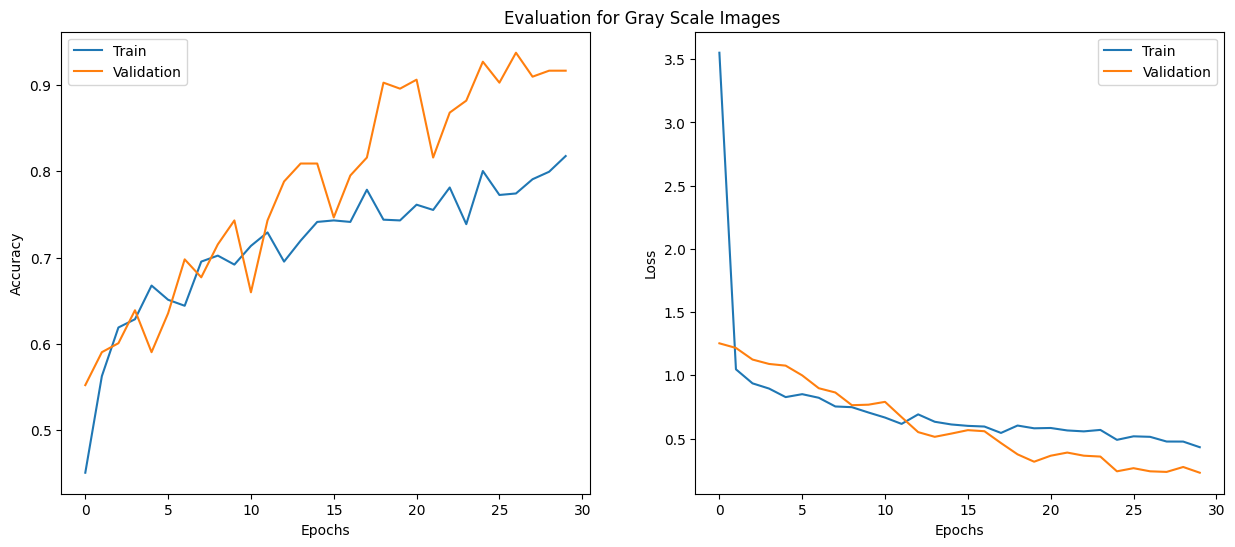

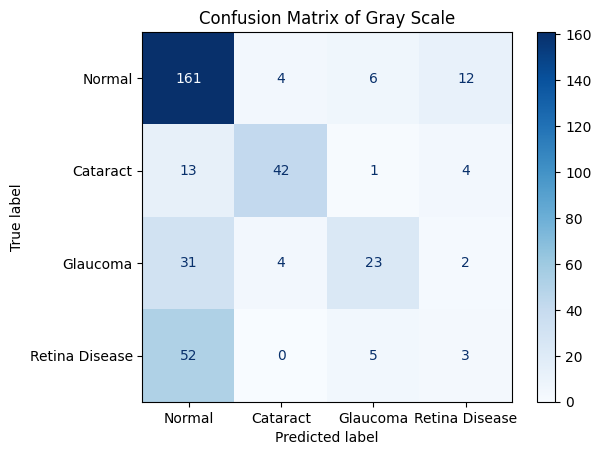

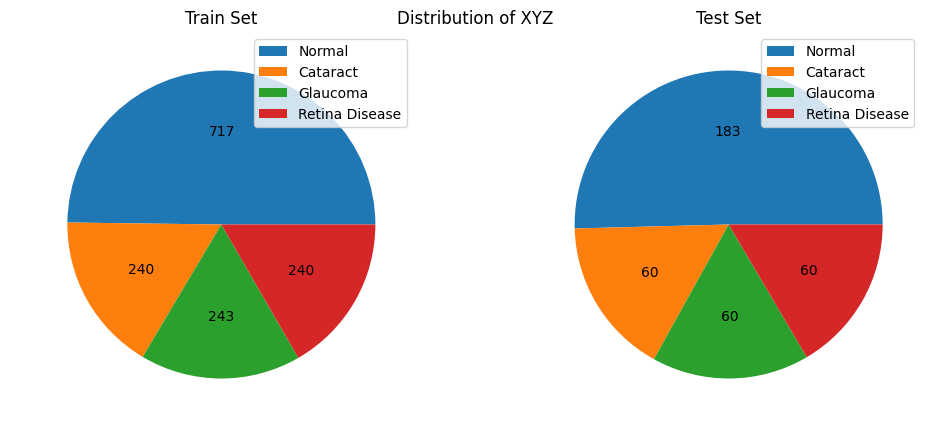

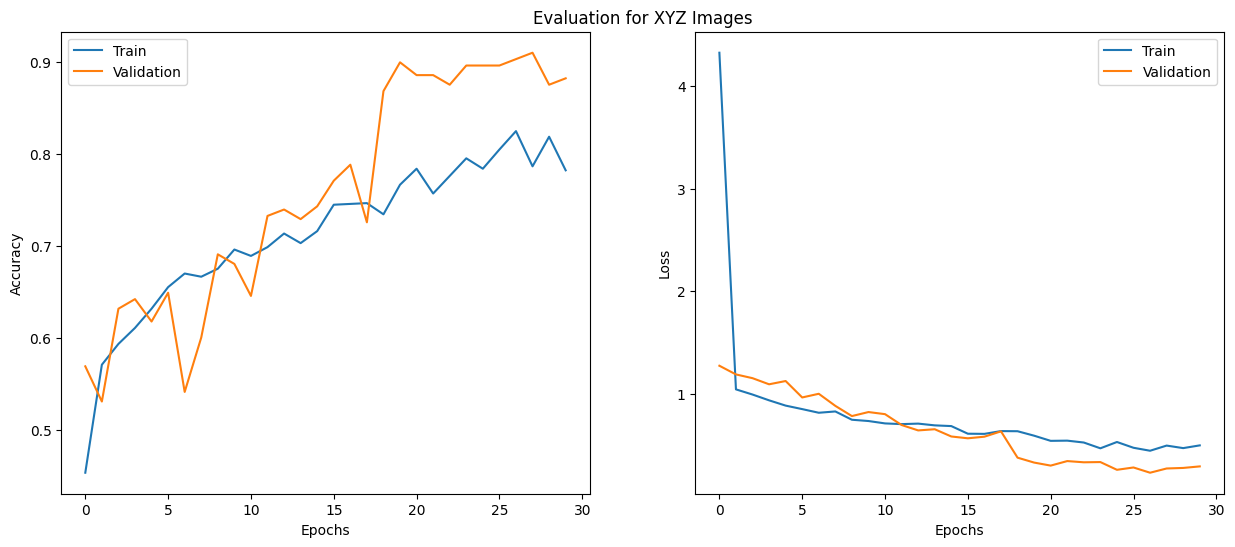

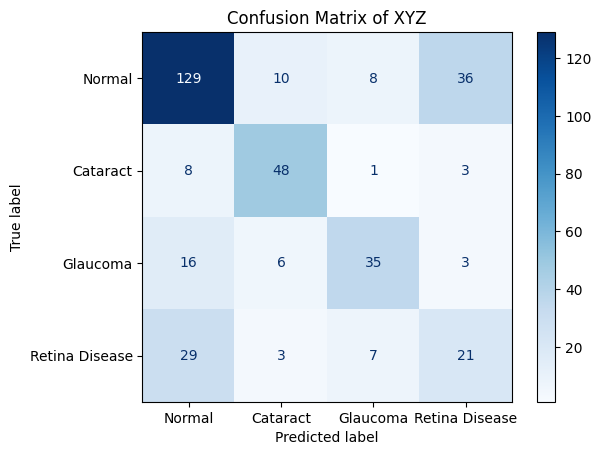

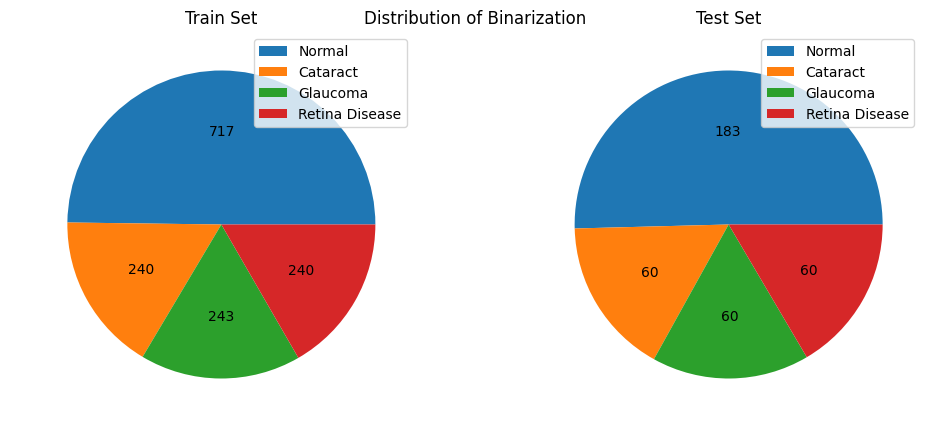

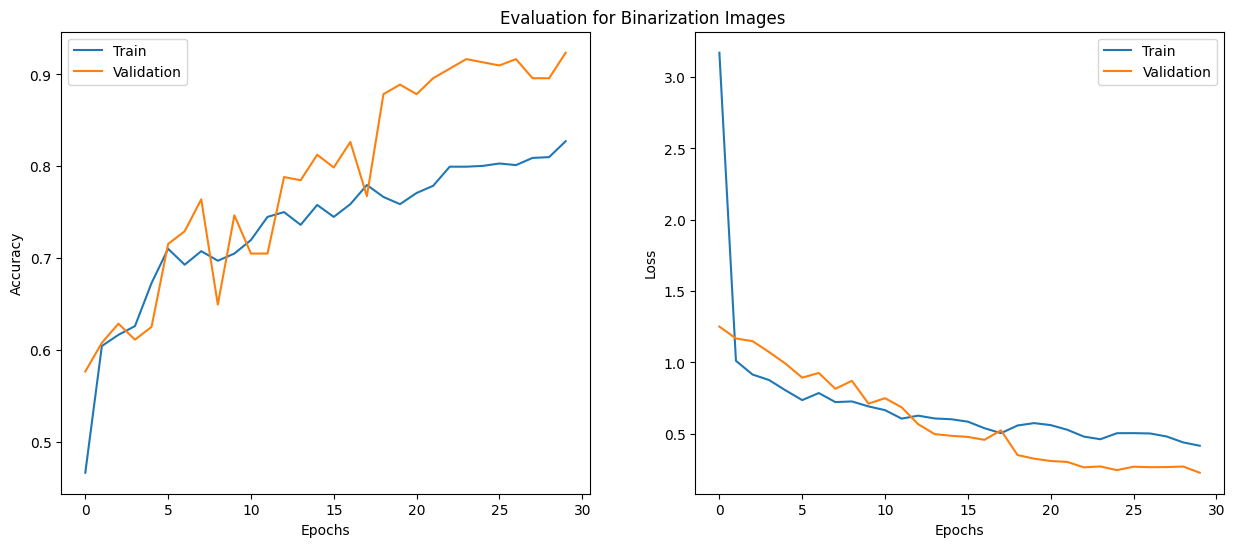

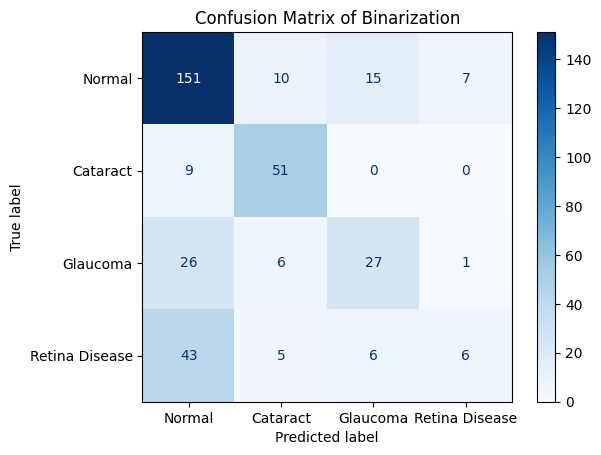

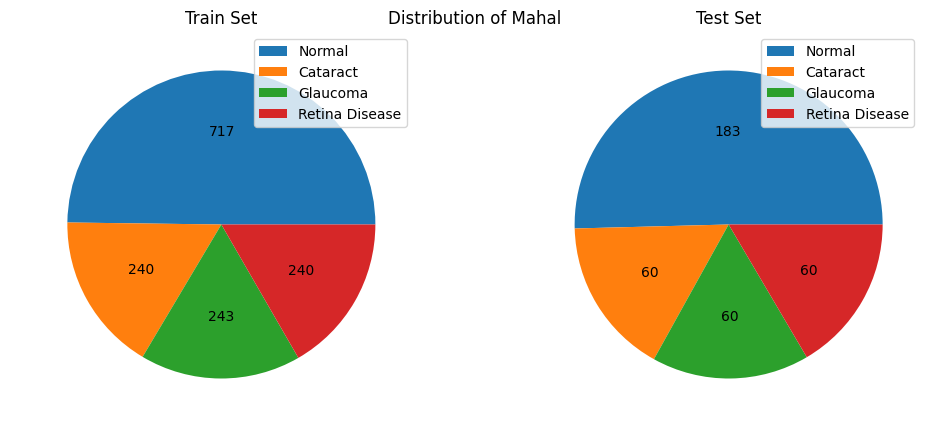

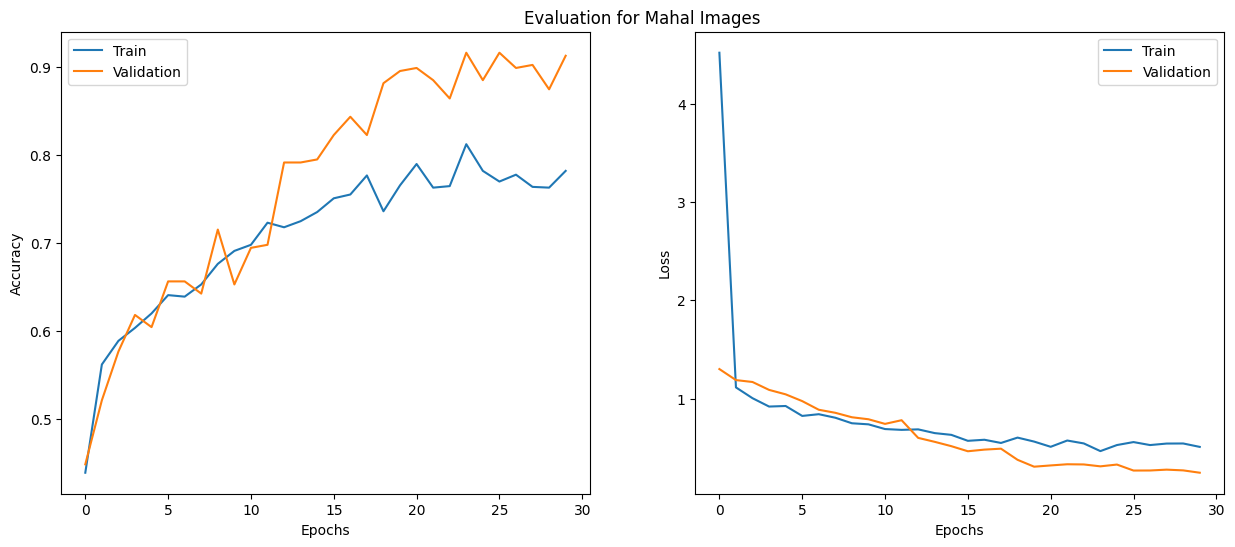

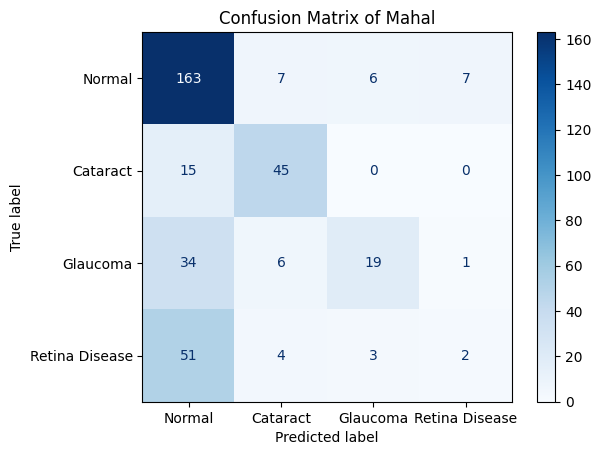

In [7]:
dict_sens = {}
dict_spec = {}
dict_acc = {}
dict_loss = {}
for i, technique in enumerate(techniques):
    try:
        X_train, y_train, X_test, y_test = read_dataset(mode=i + 7)
        Helper.plot_pie_sets([np.argmax(y_train, axis=1), np.argmax(y_test, axis=1)], technique)
        model = create_model()
        model, acc, val_acc, loss, val_loss, test_acc, test_loss = Cross_Validation(model, X_train, y_train, X_test, y_test)
        dict_acc[technique] = test_acc
        dict_loss[technique] = test_loss
        Helper.plot_history([acc, val_acc, loss, val_loss], technique)
        sensitivity, specificity = Helper.plot_conf_matrix(model, X_test, y_test, technique)
        dict_sens[technique] = sensitivity
        dict_spec[technique] = specificity
    except Exception as e:
        print("!" * 100)
        print(f"THERE IS A PROBLEM WITH {technique}")
        print("!" * 100)
        continue


In [8]:
classes = list(dict_sens.keys())
values1 = list(dict_sens.values())
values2 = list(dict_spec.values())

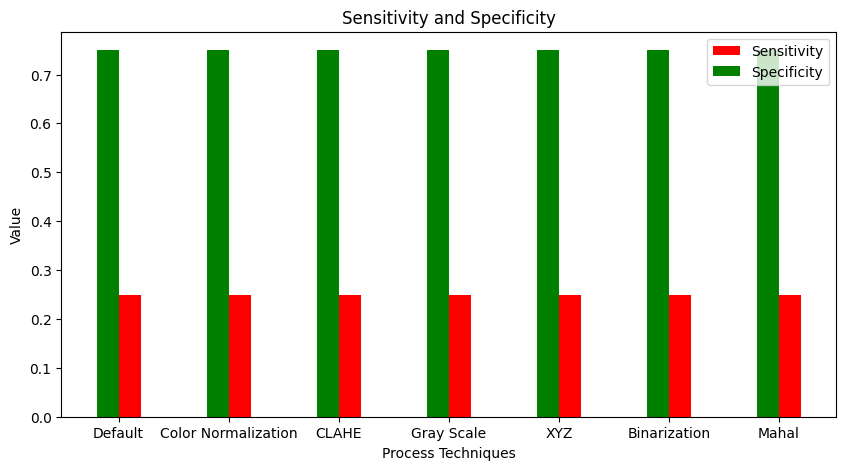

<Figure size 640x480 with 0 Axes>

In [9]:
fig = plt.figure(figsize=(10, 5))

# creating the bar plot
plt.bar(classes, values1, color='red',
        width=0.2, label="Sensitivity", align="edge")
plt.bar(classes, values2, color='green',
        width=-0.2, label="Specificity", align="edge")

plt.xlabel("Process Techniques")
plt.ylabel("Value")
plt.title("Sensitivity and Specificity")
plt.legend(loc=0)
plt.savefig("Plots/sens_spec.png")

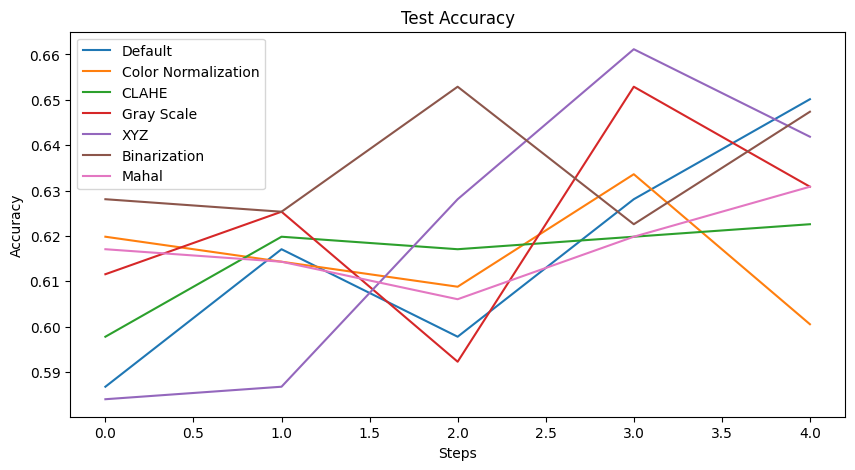

In [19]:
fig = plt.figure(figsize=(10, 5))
for technique in techniques:
    plt.plot(dict_acc[technique])
plt.title("Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Steps")
plt.legend(techniques, loc=0)
plt.savefig("Plots/result_acc.png")

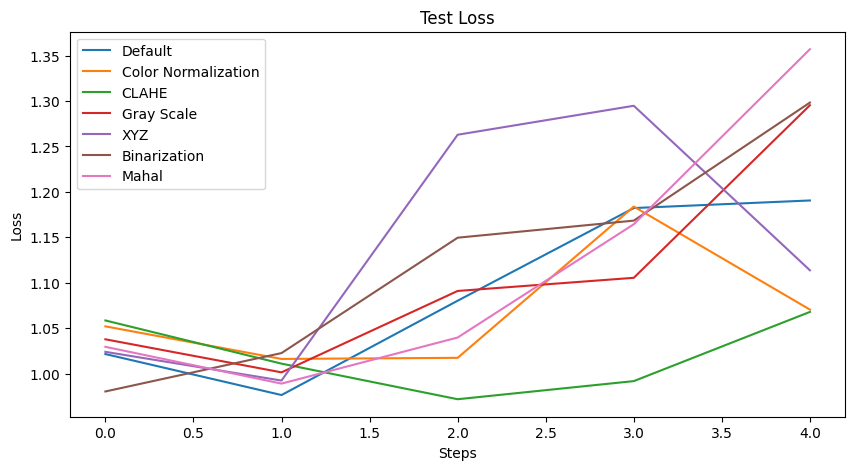

In [18]:
fig = plt.figure(figsize=(10, 5))
for technique in techniques:
    plt.plot(dict_loss[technique])
plt.title("Test Loss")
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.legend(techniques, loc=0)
plt.savefig("Plots/result_loss.png")